# DCGAN
### This notebook contains an implementation of the model described [here](https://arxiv.org/abs/1511.06434)

In [1]:
%%bash
mkdir -p $CONDA_PREFIX/etc/conda/activate.d
echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/' > $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh

bash: /home/chen/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)


In [1]:
import tensorrt
print(tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

8.5.1.7
[11/09/2022-19:57:04] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars


In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2022-11-12 11:56:41.168996: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1 Physical GPUs, 1 Logical GPU


2022-11-12 11:56:48.912239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 11:56:49.160557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 11:56:49.160668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 11:56:49.162030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset

### Loading

In [1]:
from scripts.data.load import load_dataset

dataset_name = "scapes"
dataset = load_dataset(dataset_name, normalize=True, batch=True, prefetch=False, cast_to_int8=False, colab=False)

Found 12000 files belonging to 1 classes.


### Training image preview

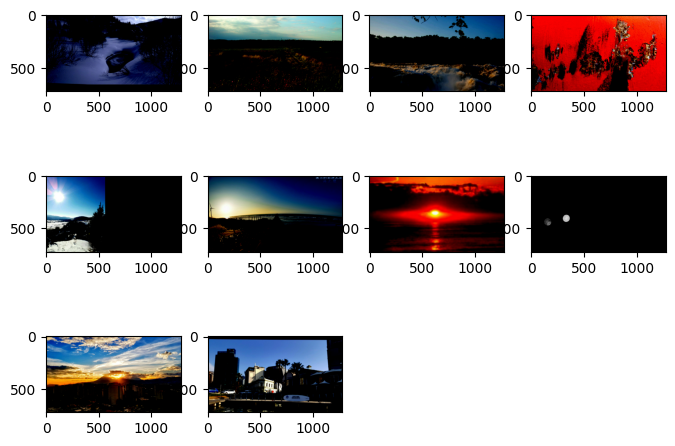

In [4]:
from scripts.data.visualization import display_images
import tensorflow as tf
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Take doesn't alter the dataset itself, so this won't affect the training
for batch in dataset.take(1):
    display_images(batch.numpy(), max_images=32)

logger.setLevel(old_level)


## Load Config

In [2]:
from config import get_config

config = get_config(dataset_name)

## Build GAN

In [3]:
from scripts.model.build import build_model
model_name = "dcgan"
generator, discriminator = build_model(model_name, dataset_name)

ResourceExhaustedError: failed to allocate memory [Op:Mul]

## Model summaries

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102400)            10342400  
                                                                 
 batch_normalization (BatchN  (None, 102400)           409600    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 10, 10, 1024)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 512)      13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 512)      2

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 360, 640, 128)     9728      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 360, 640, 128)     0         
                                                                 
 dropout (Dropout)           (None, 360, 640, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 320, 256)     819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 180, 320, 256)     0         
                                                                 
 dropout_1 (Dropout)         (None, 180, 320, 256)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 160, 512)     

## Test Generator output

2022-11-12 11:58:03.871440: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-12 11:58:04.382727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-12 11:58:05.328976: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


5.6112065e-05 0.0004994832 -0.00027948603


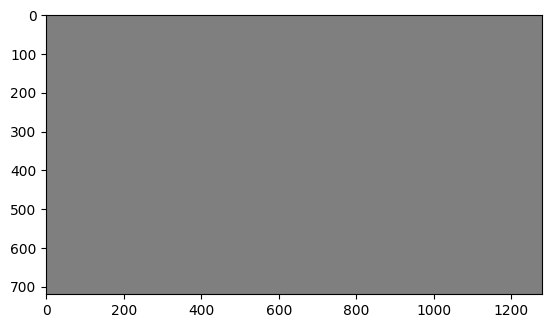

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

input_noise = tf.random.normal([1, config['dataset']['dcgan']['generator']['len_seed']])
generated_image = generator(input_noise, training=False)[0]
print(np.average(generated_image), np.max(generated_image), np.min(generated_image))
# generated_image[0]
plt.imshow((generated_image + 1)/2)

## Test Discriminator output

In [10]:
decision = discriminator(np.reshape(
                                        generated_image,                    
                                        (1, 
                                        config['dataset']['height'], 
                                        config['dataset']['width'], 
                                        config['dataset']['num_color_channels'])
                                    ),
                                    training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50000083]], dtype=float32)>

## Get optimizers

In [11]:
generator_optimizer = config['dataset'][model_name]['generator']['optimizer']
discriminator_optimizer = config['dataset'][model_name]['discriminator']['optimizer']

## Training functions

## Training the model

In [6]:
generator_optimizer.learning_rate = 0.0002
discriminator_optimizer.learning_rate = 0.00002

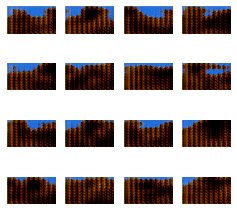

Total training time (in seconds): 1343.866194486618


In [22]:
import time
from tensorflow.keras.optimizers import Adam

# generator_optimizer = config['dataset'][model_name]['generator']['optimizer']
# discriminator_optimizer = config['dataset'][model_name]['discriminator']['optimizer']

start = time.time()
train(dataset, epochs=1)
end = time.time()
print(f'Total training time (in seconds): {end - start}')

In [67]:
generator.save('/content/generator_10_epochs')

In [5]:
import tensorflow as tf

generator = tf.keras.models.load_model('/content/generator')

## Rescaling image output from [-1, 1] to [0, 255]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102400)            10342400  
                                                                 
 batch_normalization (BatchN  (None, 102400)           409600    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 10, 10, 1024)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 512)      13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 512)      2

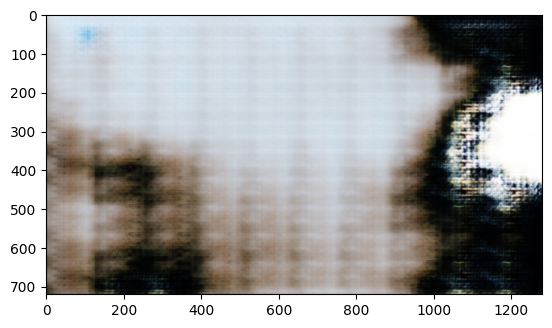

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

gen = tf.keras.models.load_model('./models/generator_3_epochs')
gen.compile()

import numpy as np

rand_seed = tf.random.normal([1, 100])
image = gen(rand_seed, training=False)[0]
image = image.numpy()
image = ((image - np.min(image)) * 255) / (np.max(image) - np.min(image))
# image
# image = ((image * 127.5) + 127.5)
image = image.astype(np.uint8)
plt.imshow(image)
plt.savefig('./models/output/example_10_epoch.png', bbox_inches='tight' )
print(gen.summary())

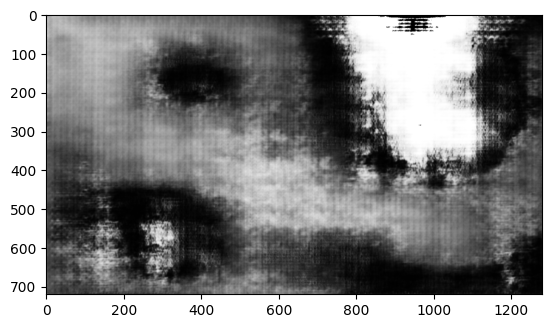

In [21]:
image = (image + 1)/(2) * 255
np.min(image), np.max(image)
# # image = np.expand_dims(image, axis=0)
# # rand_seed
plt.imshow(image[:, :, 0], cmap='gray')

## Saving the model

In [32]:
generator.save('./models/generator')

In [33]:
discriminator.save('./models/discriminator')

## Download folder

In [ ]:
!tar cvf toy_model_batch_processing.tgz toy_model_batch_processing/

In [ ]:
!tar cvf generator.tgz ./models/generator